In [1]:
import numpy as np
import torch
import torch.nn as nn
from GRU_pipeline import DataHolder, paths, Pipeline, simulate_randomness, explore_tresh
from models import GRUModel, EmbedsModel
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import pandas as pd

from torch.optim import Adam

from torch.utils.data import TensorDataset, DataLoader

DH = DataHolder(**paths)

In [2]:
output = DH.make_train_test_datasets(test_size = .15, val_size = .17)
class_weights = output['class_weights']
openface_1  = output['datasets']['openface_1']
openface_2  = output['datasets']['openface_2']
opensmile_1 = output['datasets']['opensmile_1']
opensmile_2 = output['datasets']['opensmile_2']

In [23]:
[a,b] = [1,2]
b

2

In [25]:
[X_train, Y_train ]= [ x[[ int(idx) for idx in set(openface_1.train_dic.keys()).union(set(openface_2.train_dic.keys())) ]] for x in  [ DH.embeds_tensors, DH.target_tensor ] ]
[X_val, Y_val     ]= [ x[[ int(idx) for idx in set(openface_1.valid_dic.keys()).union(set(openface_2.valid_dic.keys())) ]] for x in  [ DH.embeds_tensors, DH.target_tensor ] ]
[X_test, Y_test   ]= [ x[[ int(idx) for idx in set(openface_1.test_dic.keys()).union(set(openface_2.test_dic.keys())) ]] for x in  [ DH.embeds_tensors, DH.target_tensor ] ]

trainloader = DataLoader(TensorDataset(X_train,Y_train), batch_size=48, shuffle=True)
validloader = DataLoader(TensorDataset(X_val,Y_val), batch_size=48, shuffle=True)
testloader  = DataLoader(TensorDataset(X_test,Y_test), batch_size=48, shuffle=True)

Epoch 0 - Total train loss 0.00217628
-------------------------------------------------- TEST --------------------------------------------------
Epoch 0 - Total test loss 0.09716379
----------------------------------------------------------------------------------------------------------
Epoch 50 - Total train loss 0.00122328
Epoch 100 - Total train loss 0.00106831
Epoch 150 - Total train loss 0.00093807
#### removing one tol ####
4
#### removing one tol ####
3
Epoch 200 - Total train loss 0.00078270
#### removing one tol ####
2
#### removing one tol ####
1
#### removing one tol ####
0
[0.76, 0.61, 0.16, 0.38, 0.68]


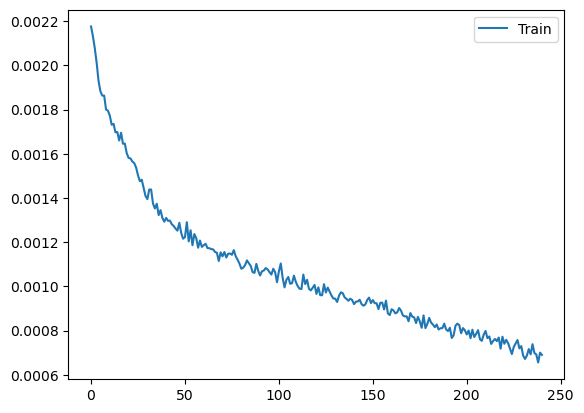

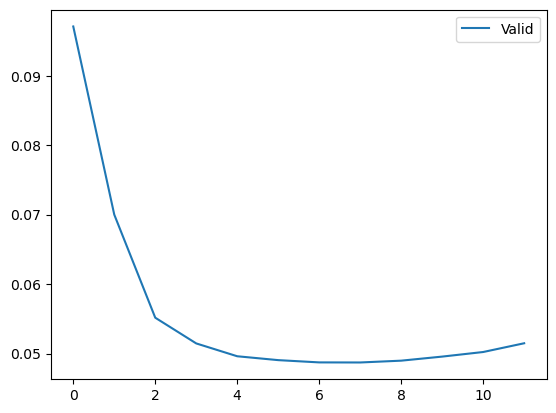

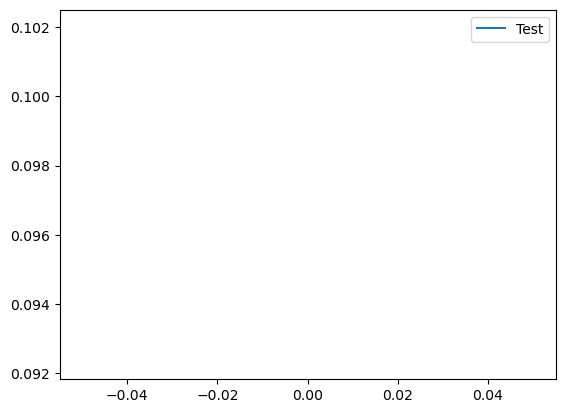

In [41]:
DH = DataHolder(**paths)
output = DH.make_train_test_datasets(test_size = .15, val_size = .17)
class_weights = output['class_weights']
openface_1  = output['datasets']['openface_1']
openface_2  = output['datasets']['openface_2']
opensmile_1 = output['datasets']['opensmile_1']
opensmile_2 = output['datasets']['opensmile_2']
[X_train, Y_train ]= [ x[[ int(idx) for idx in set(openface_1.train_dic.keys()).union(set(openface_2.train_dic.keys())) ]] for x in  [ DH.embeds_tensors, DH.target_tensor ] ]
[X_val, Y_val     ]= [ x[[ int(idx) for idx in set(openface_1.valid_dic.keys()).union(set(openface_2.valid_dic.keys())) ]] for x in  [ DH.embeds_tensors, DH.target_tensor ] ]
[X_test, Y_test   ]= [ x[[ int(idx) for idx in set(openface_1.test_dic.keys()).union(set(openface_2.test_dic.keys())) ]] for x in  [ DH.embeds_tensors, DH.target_tensor ] ]

trainloader = DataLoader(TensorDataset(X_train,Y_train), batch_size=48, shuffle=True)

model = EmbedsModel(layer_dim=[256,128,64],dropout=.25)

criterion = nn.BCEWithLogitsLoss(weight=class_weights)
optimizer = Adam(model.parameters(), lr=5e-5)

all_train_loss = []
all_valid_loss = []
all_test_loss = []

device=torch.device('cpu')
tol = 5

for epoch in range(1000):
    model.train() 
    total_train_loss = 0

    for X_, Y_ in trainloader:
        X_, Y_ = X_.to(device), Y_.to(device)
        model.to(device)
        
        optimizer.zero_grad()
        
        Y_pred = model(X_)   
            
        loss = criterion(Y_pred, Y_)
        loss.backward()
        optimizer.step()
    
        if epoch%1 == 0:
            total_train_loss   += loss.item()/X_.size(0)/len(trainloader)
    
    all_train_loss.append(total_train_loss)
            
    if epoch%50 == 0:        
        print(f"Epoch {epoch} - Total train loss {total_train_loss:.8f}")
    
    if epoch%20 == 0:
        model.eval() 
        with torch.no_grad():
            total_valid_loss = 0  

            X_val, Y_val = X_val.to(device), Y_val.to(device)

            Y_pred = model(X_val)   
                
            val_loss = criterion(Y_pred, Y_val).item()

            if epoch>100 and val_loss > all_valid_loss[-1]:
                tol += -1
                if tol==0 :
                    break
            all_valid_loss.append(val_loss)
    if epoch%300 == 0:
        model.eval() 
        with torch.no_grad():

            X_test, Y_test = X_test.to(device), Y_test.to(device)

            Y_pred = model(X_test)   
                
            test_loss = criterion(Y_pred, Y_test).item()

            print('-'*50, 'TEST', '-'*50)
            print(f"Epoch {epoch} - Total test loss {test_loss:.8f}")
            print('-'*106)
            all_test_loss.append(test_loss)
model.to(torch.device('cpu'))
model.eval()
Y_pred = model(X_test).detach().numpy()
Y_true = Y_test.detach().numpy()

scores = []
for i in range(Y_pred.shape[1]):
    y_pred = Y_pred[:,i]
    y_test = Y_test[:,i]
    tresholds = np.linspace(y_pred.min(), y_pred.max(), 50)
    f1 = np.array([ f1_score(y_test, np.where(y_pred>t,1,0)) for t in tresholds[:-1] ]).max()
    scores.append(np.round(f1,2))

print(scores)

plt.plot(all_train_loss, label='Train')
plt.legend()
plt.show()
plt.plot(all_valid_loss, label='Valid')
plt.legend()
plt.show()
plt.plot(all_test_loss, label='Test')
plt.legend()
plt.show()

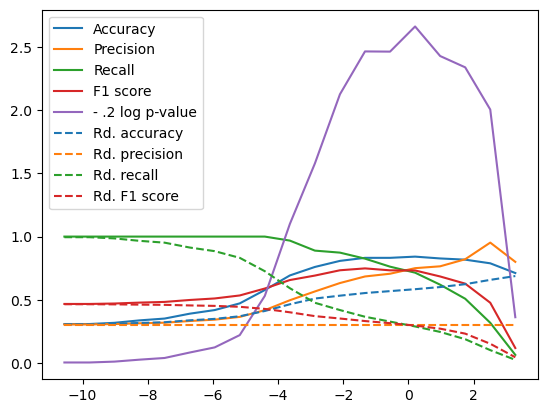

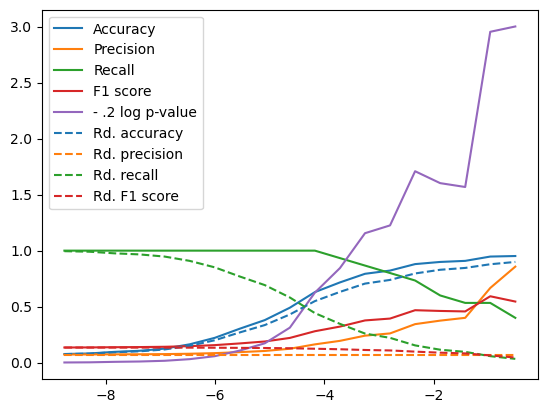

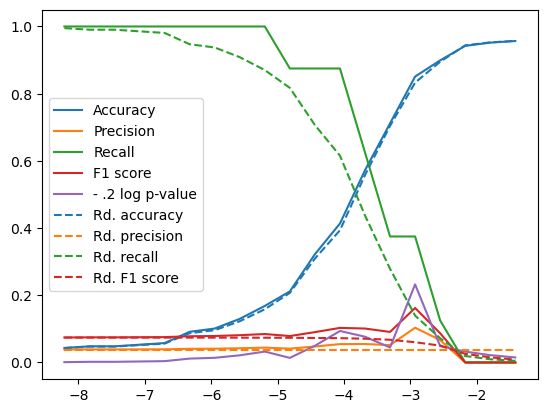

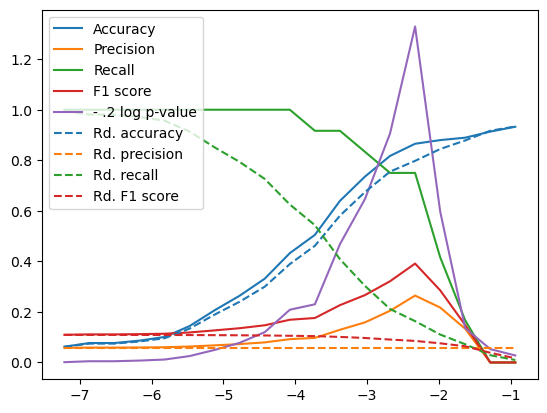

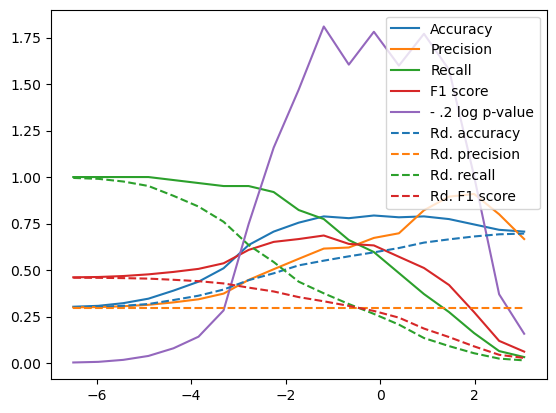

In [42]:
res = pd.DataFrame(model(X_test).detach().numpy(), columns=DH.target_col)
true = pd.DataFrame(Y_test.detach().numpy(), columns=DH.target_col)
for cat in res.columns:
    ax = explore_tresh(true[cat],res[cat]).plot(color =list(mcolors.TABLEAU_COLORS.values()) )
    simulate_randomness(true[cat], res[cat]).plot( ax=ax, linestyle='dashed',color =list(mcolors.TABLEAU_COLORS.values()))

Training on cpu
loss epoch 12: 0.001347
loss epoch 24: 0.001282
loss epoch 36: 0.001222
loss epoch 48: 0.001195
loss epoch 60: 0.001133


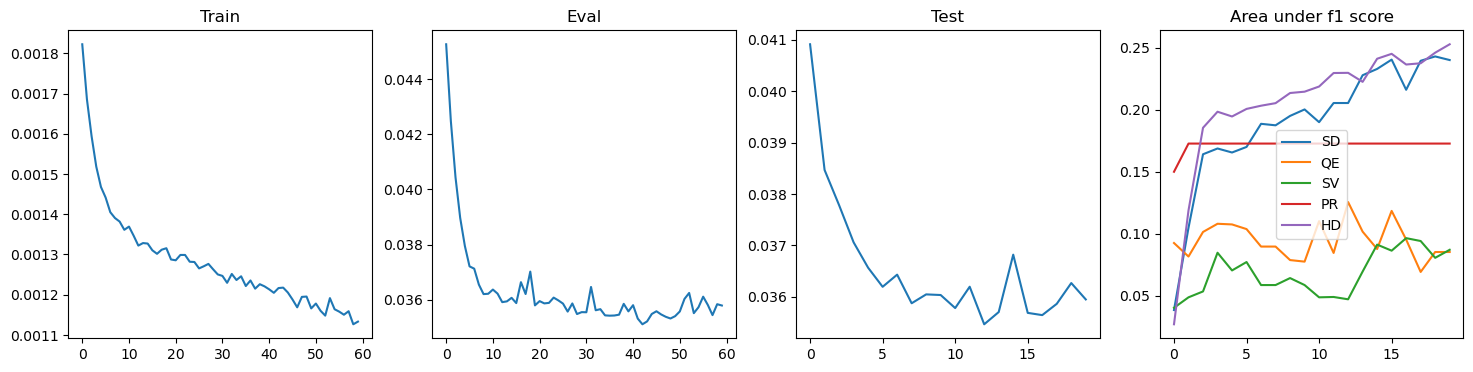

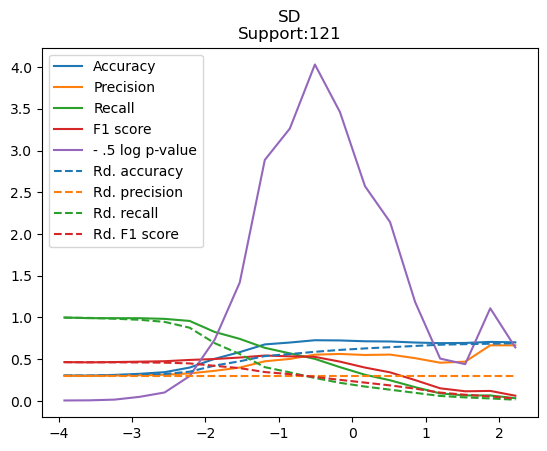

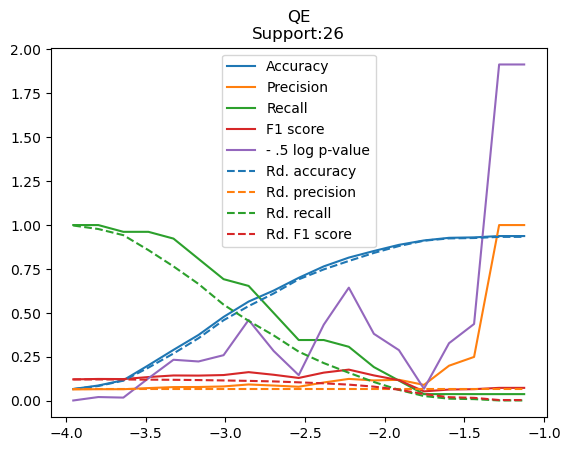

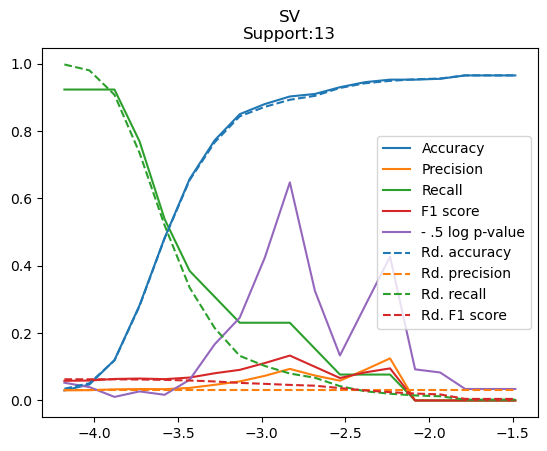

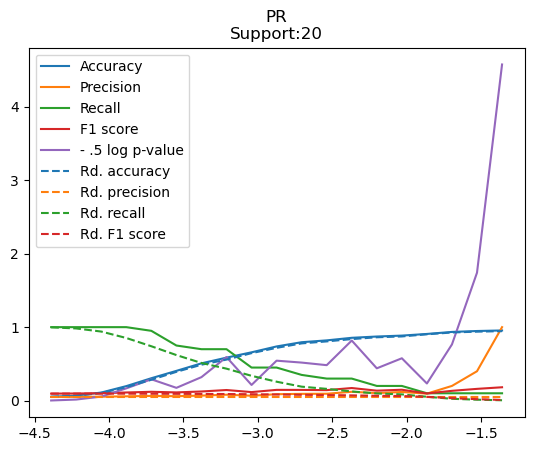

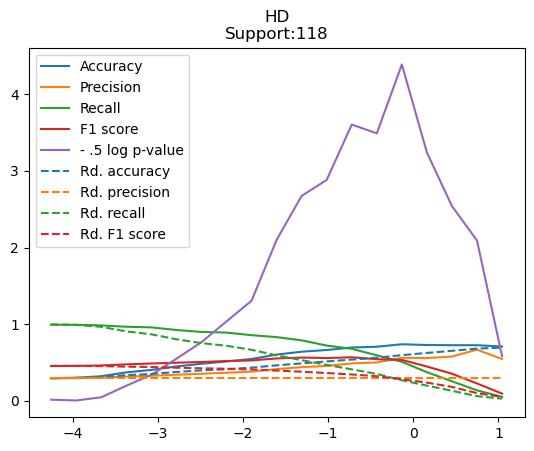

[0.24004329004329006,
 0.08533333333333333,
 0.08711111111111111,
 0.17272727272727273,
 0.25275555555555557]

In [6]:
model_args = {
    'input_dim':17,
    'hidden_dim':32,
    'layer_dim':2,
    'output_dim':5,
    'dropout_prob':.1
}

args={
    'model': GRUModel(**model_args),
    'features_1':openface_1,
    'features_2':openface_2,
    #'features_1':opensmile_1,
    #'features_2':opensmile_2,
    'class_weights':class_weights
}
pipebce = Pipeline(**args)
pipebce.train(epoch=60,lr=1e-3, early_stop=False, tolerance=20)
pipebce.plot_losses()
pipebce.eval_model(plot=True) #the interpretation of the plots is later in the notebook

In [ ]:
[([0.73, 0.53, 0.15, 0.24, 0.75], [768, 512, 256, 60]), ([0.8, 0.54, 0.42, 0.26, 0.73], [512, 64]), ([0.75, 0.46, 0.27, 0.31, 0.64], [128]), ([0.68, 0.59, 0.22, 0.23, 0.64], [1024, 512, 64]), ([0.77, 0.69, 0.32, 0.26, 0.58], [128, 64, 64, 64])]

Training on cpu
loss epoch 12: 0.001450
loss epoch 24: 0.001422
loss epoch 36: 0.001438
loss epoch 48: 0.001436
loss epoch 60: 0.001434


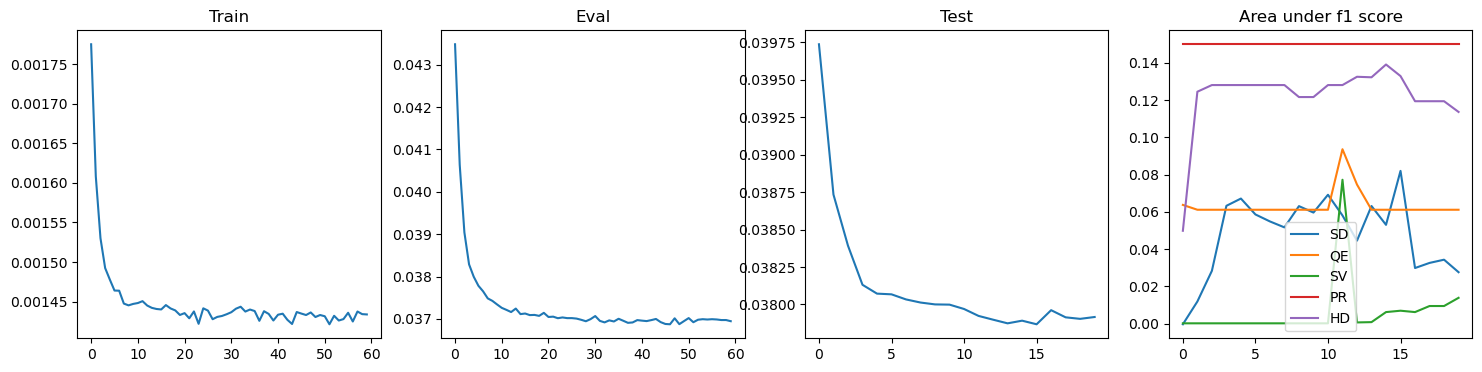

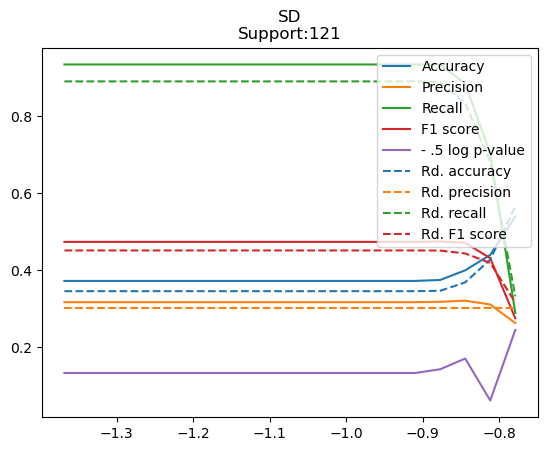

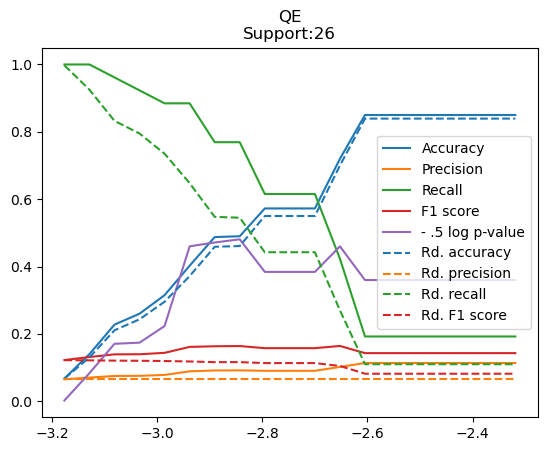

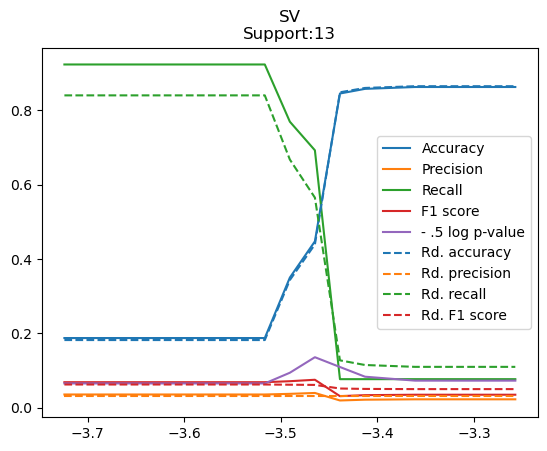

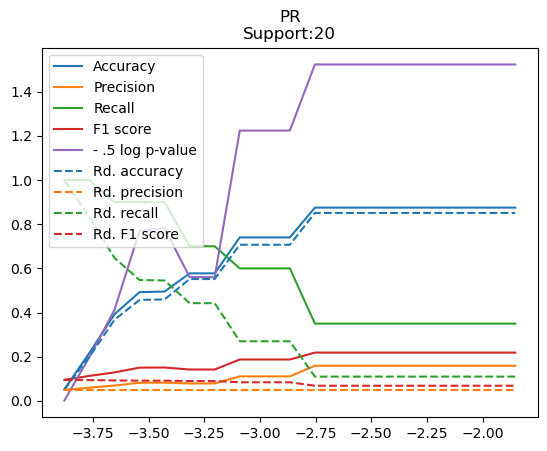

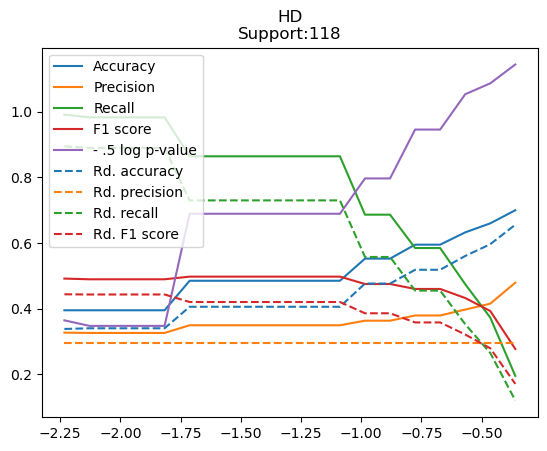

[0.027610132158590317,
 0.061142857142857124,
 0.013849372384937234,
 0.15,
 0.11366071428571439]

In [3]:
model_args = {
    'input_dim':23,
    'hidden_dim':32,
    'layer_dim':2,
    'output_dim':5,
    'dropout_prob':.1
}

args={
    'model': GRUModel(**model_args),
    #'features_1':openface_1,
    #'features_2':openface_2,
    'features_1':opensmile_1,
    'features_2':opensmile_2,
    'class_weights':class_weights
}
pipebce = Pipeline(**args)
pipebce.train(epoch=60,lr=1e-3, early_stop=False, tolerance=20)
pipebce.plot_losses()
pipebce.eval_model(plot=True) #the interpretation of the plots is later in the notebook

### Compare classifier to randomness ###

Let our problem be a binary classification ($0$: negative; $1$: positive) with positive class of probability $p\in (0,1)$.

We sample $N$ points.

Since it is binomial we'll consider that if we put our points in a ```y = np.array``` then ```y.mean()``` is a good estimator of $p$.

We have a classifier that outputs probabilities in $(0,1)$ and we want to measure its relevance. There exist a wide range of classical metrics but since our data is highly imabalanced, it is impossible to make any sence of them. Additionnaly, most of these metrics depend on a threshold choice, and due to imbalance, the one yielding the highest metric does not necessarily garantee the relevance of the model. Therefore, our objective is to compare our model to randomness with either _any_ threshold or for _all_ thresholds.

To compare it with randomness, I assume that if our classifier is random, the actual label of any point is independant of the output of the model. I only need to calculate expected TP, FP, TN, and FN for a given threshold $t \in (0,1)$ to calculate the metrics and compare that to the performance of our model.

I chose the following method:

I gather all my samples ```y``` and all the outputs of our model ```y_pred```.

To estimate the performance of our model, for each threshold $t \in (0,1)$, I compute the metrics from ```sklearn.metrics``` package ```accuracy_score, precision_score, recall_score, f1_score``` between ```y``` and ```np.where(y_pred>t,1,0)``` (which converts probs to $1$ or $0$). Note that these metrics can all be computed with y positive (TP), false positive (FP), true negative (TN), and false negative (FN).

For a given treshold t, the total number of predicted positive by the model is```A_t  = np.where(y_pred>t,1,0).sum() = a_t * N``` with ```a_t = np.where(y_pred>t,1,0).mean()```. As we know that TP equals to P... = p * A_t, therefore, TP = p * a_t * N.

For a given treshold $t$, we have a proportion of ```a_t = np.where(y_pred>t,1,0).mean()``` predicted positive. Among them, a proportion of $P(y=1|y\_pred=1) = P(y=1)=p$ are TP since the actual labels are independant from the predicted ones. Therefore, $TP = N*a_t*p$, and since the metric I want are ratios, I can divide it right away by $N$, which gives me $TP = a_t*p$.

Similarly, I can calculate that:
- $FP = a_t*(1-p)$
- $TN = (1-a_t)*(1-p)$
- $FN = (1-a_t)*p$

Having:
- $accuracy = (TP+TN)/(TP+FP+FN+TN)$
- $precision = TP/(TP+FP)
- $recall = TP/(TP+FN)
- $f1 = 2 \frac{precision *recall}{precision + recall}$

We get after simplifications that:
- $accuracy = a_t*(2*p-1) + 1 - p$
- $p$
- $a_t$
- $2\frac{p*a_t}{p + a_t}$

Which gives two curbs for each metric that allow to compare the model predictions to 'randomness'. Also, to compare models, we can look at the highest difference between actual metric and random metric curbs.

Additionnaly, I use the classic $\chi$-square test that gives a measure of how likely are these results given that these two set of samples are from two independant laws. This adds also a metric to evaluate thresholds and models: for each threshold $t$, I compute: ```sklearn.feature_selection.chi2( np.where(y_pred>t,1,0).reshape(-1,1) , y )[1][0]```

All-in-all, the code looks like this:

```python
def simulate_randomness(true, y_pred):
    tresh = np.linspace(y_pred.min(),y_pred.max(),20) #because I want this to be visually clear and not shrinked because all outputs are between .9 and .91
    p=y.sum()/y.shape[0]
    func = lambda t : np.where(y_pred > t,1,0).mean() #a_t
    out = [(
        func(t)*(2*p-1) + 1 - p,
        p,
        func(t),
        (2*p*func(t)) / (p + func(t)) if func(t) > 0 else np.nan
    ) for t in tresh[:-1]] #see below
    out = pd.DataFrame(out, columns=['Rd. accuracy', 'Rd. precision', 'Rd. recall', 'Rd. F1 score'], index=tresh[:-1])
    return out

def explore_tresh(y, y_pred):
    tresh = np.linspace(y_pred.min(),y_pred.max(),20)
    out = [(
        accuracy_score(y, np.where(y_pred>t,1,0)),
        precision_score(y, np.where(y_pred>t,1,0), zero_division=1),
        recall_score(y, np.where(y_pred>t,1,0)),
        f1_score(y, np.where(y_pred>t,1,0)),
        chi2( np.where(y_pred>t,1,0).reshape(-1,1) , y )[1][0]
    ) for t in tresh[:-1]] # don't take the last one otherwise precision can't be computed
    out = pd.DataFrame(out, columns=['Accuracy', 'Precision', 'Recall', 'F1 score', '- .5 log p-value'], index=tresh[:-1])
    out['- .5 log p-value'] = - np.log10(out['- .5 log p-value']) / 2
    return out

#--- y = ..., y_pred = ... ---#

#y = true values for a class
#y_pred = outputs of the model for the same class

rd = simulate_randomness(y,y_pred)
res = explore_tresh(y,y_pred)

ax = res.plot( color =list(mcolors.TABLEAU_COLORS.values()) )
rd.plot( ax=ax, linestyle='dashed',color =list(mcolors.TABLEAU_COLORS.values()) )
plt.show()
```

So on the previous output you can see one train, valid, and test losses evolution through training and the evolution of the max difference between random and actual f1 score. Note that the latter could be used to define early stopping instead of valid loss.

Under, you can see all random/actual metrics for each class + the $-\frac{1}{2}log(p\_value)$ of the predictions. When the latter equals 1, it means our model has a predictive power with 99% of insurance (2 is 99.99%) but it looks a little high to me.

We can observe that our model's results are very significative for the classes with a large support (the architercture shown here is fine tuned for them).

In [82]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv('results_colab.csv')
df = df.astype({'hidden_dim':str, 'layer_dim':str, 'dropout':str})
df.head(2)

,loss,hidden_dim,layer_dim,dropout,residxSD,residxQE,residxSV,residxPR,residxHD,residexTL,resvalSD,resvalQE,resvalSV,resvalPR,resvalHD,resvalTL
0,MSELoss(),4,2,0.1,29,1,4,25,29,29,0.022,-0.014,0.030,0.152,0.036,0.058
1,MSELoss(),4,2,0.1,0,1,7,20,1,29,0.034,0.000,0.027,0.143,-0.031,0.058


In [86]:
df = pd.get_dummies(df)
resval_cols = ['resvalSD', 'resvalQE', 'resvalSV', 'resvalPR', 'resvalHD']
hidden_dim_col = ['hidden_dim_16', 'hidden_dim_32','hidden_dim_4', 'hidden_dim_8'] # high card = wider, low card = narrow
layer_dim_col = ['layer_dim_16', 'layer_dim_2','layer_dim_4', 'layer_dim_8'] # high card = shallow, low card = deep wtf
loss_col=['loss_BCELoss()', 'loss_MSELoss()'] # no influence let alone shitty columns where it's BCE
dropout_col = ['dropout_0.1', 'dropout_0.2'] # no influence or .1 better
df.columns

Index(['residxSD', 'residxQE', 'residxSV', 'residxPR', 'residxHD', 'residexTL',
       'resvalSD', 'resvalQE', 'resvalSV', 'resvalPR', 'resvalHD', 'resvalTL',
       'loss_BCELoss()', 'loss_MSELoss()', 'hidden_dim_16', 'hidden_dim_32',
       'hidden_dim_4', 'hidden_dim_8', 'layer_dim_16', 'layer_dim_2',
       'layer_dim_4', 'layer_dim_8', 'dropout_0.1', 'dropout_0.2'],
      dtype='object')

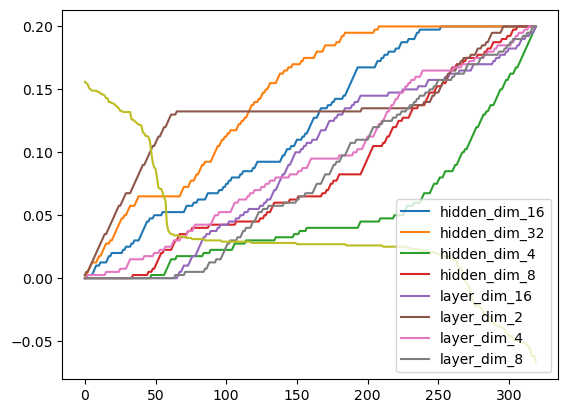

In [88]:
col = 'resvalSD'
(df.sort_values(by=col, ascending=False)[hidden_dim_col + layer_dim_col].cumsum().reset_index(drop=True)/400).plot()
plt.plot(df[col].sort_values(ascending=False).reset_index(drop=True))
plt.show()

In [84]:
df.groupby(['layer_dim', 'hidden_dim'])[resval_cols].agg(['mean', 'max'])

In [101]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from GRU_pipeline import simulate_randomness, explore_tresh
import matplotlib.colors as mcolors
from sklearn.feature_selection import chi2

cats = ['SD', 'QE', 'SV', 'PR', 'HD', "None"]

audio      = pd.DataFrame(np.load("results/audio_prediction.npy"), columns = ['SD', 'QE', 'SV', 'PR', 'HD', "None"])
multimodal = pd.DataFrame(np.load("results/multimodal_prediction.npy"), columns = ['SD', 'QE', 'SV', 'PR', 'HD', "None"])
text       = pd.DataFrame(np.load("results/text_prediction.npy"), columns = ['SD', 'QE', 'SV', 'PR', 'HD', "None"])
video      = pd.DataFrame(np.load("results/video_prediction.npy"), columns = ['SD', 'QE', 'SV', 'PR', 'HD', "None"])

models     = [text, audio, video , multimodal]

true       = pd.DataFrame(np.load("results/true.npy"), columns = ['SD', 'QE', 'SV', 'PR', 'HD', "None"])

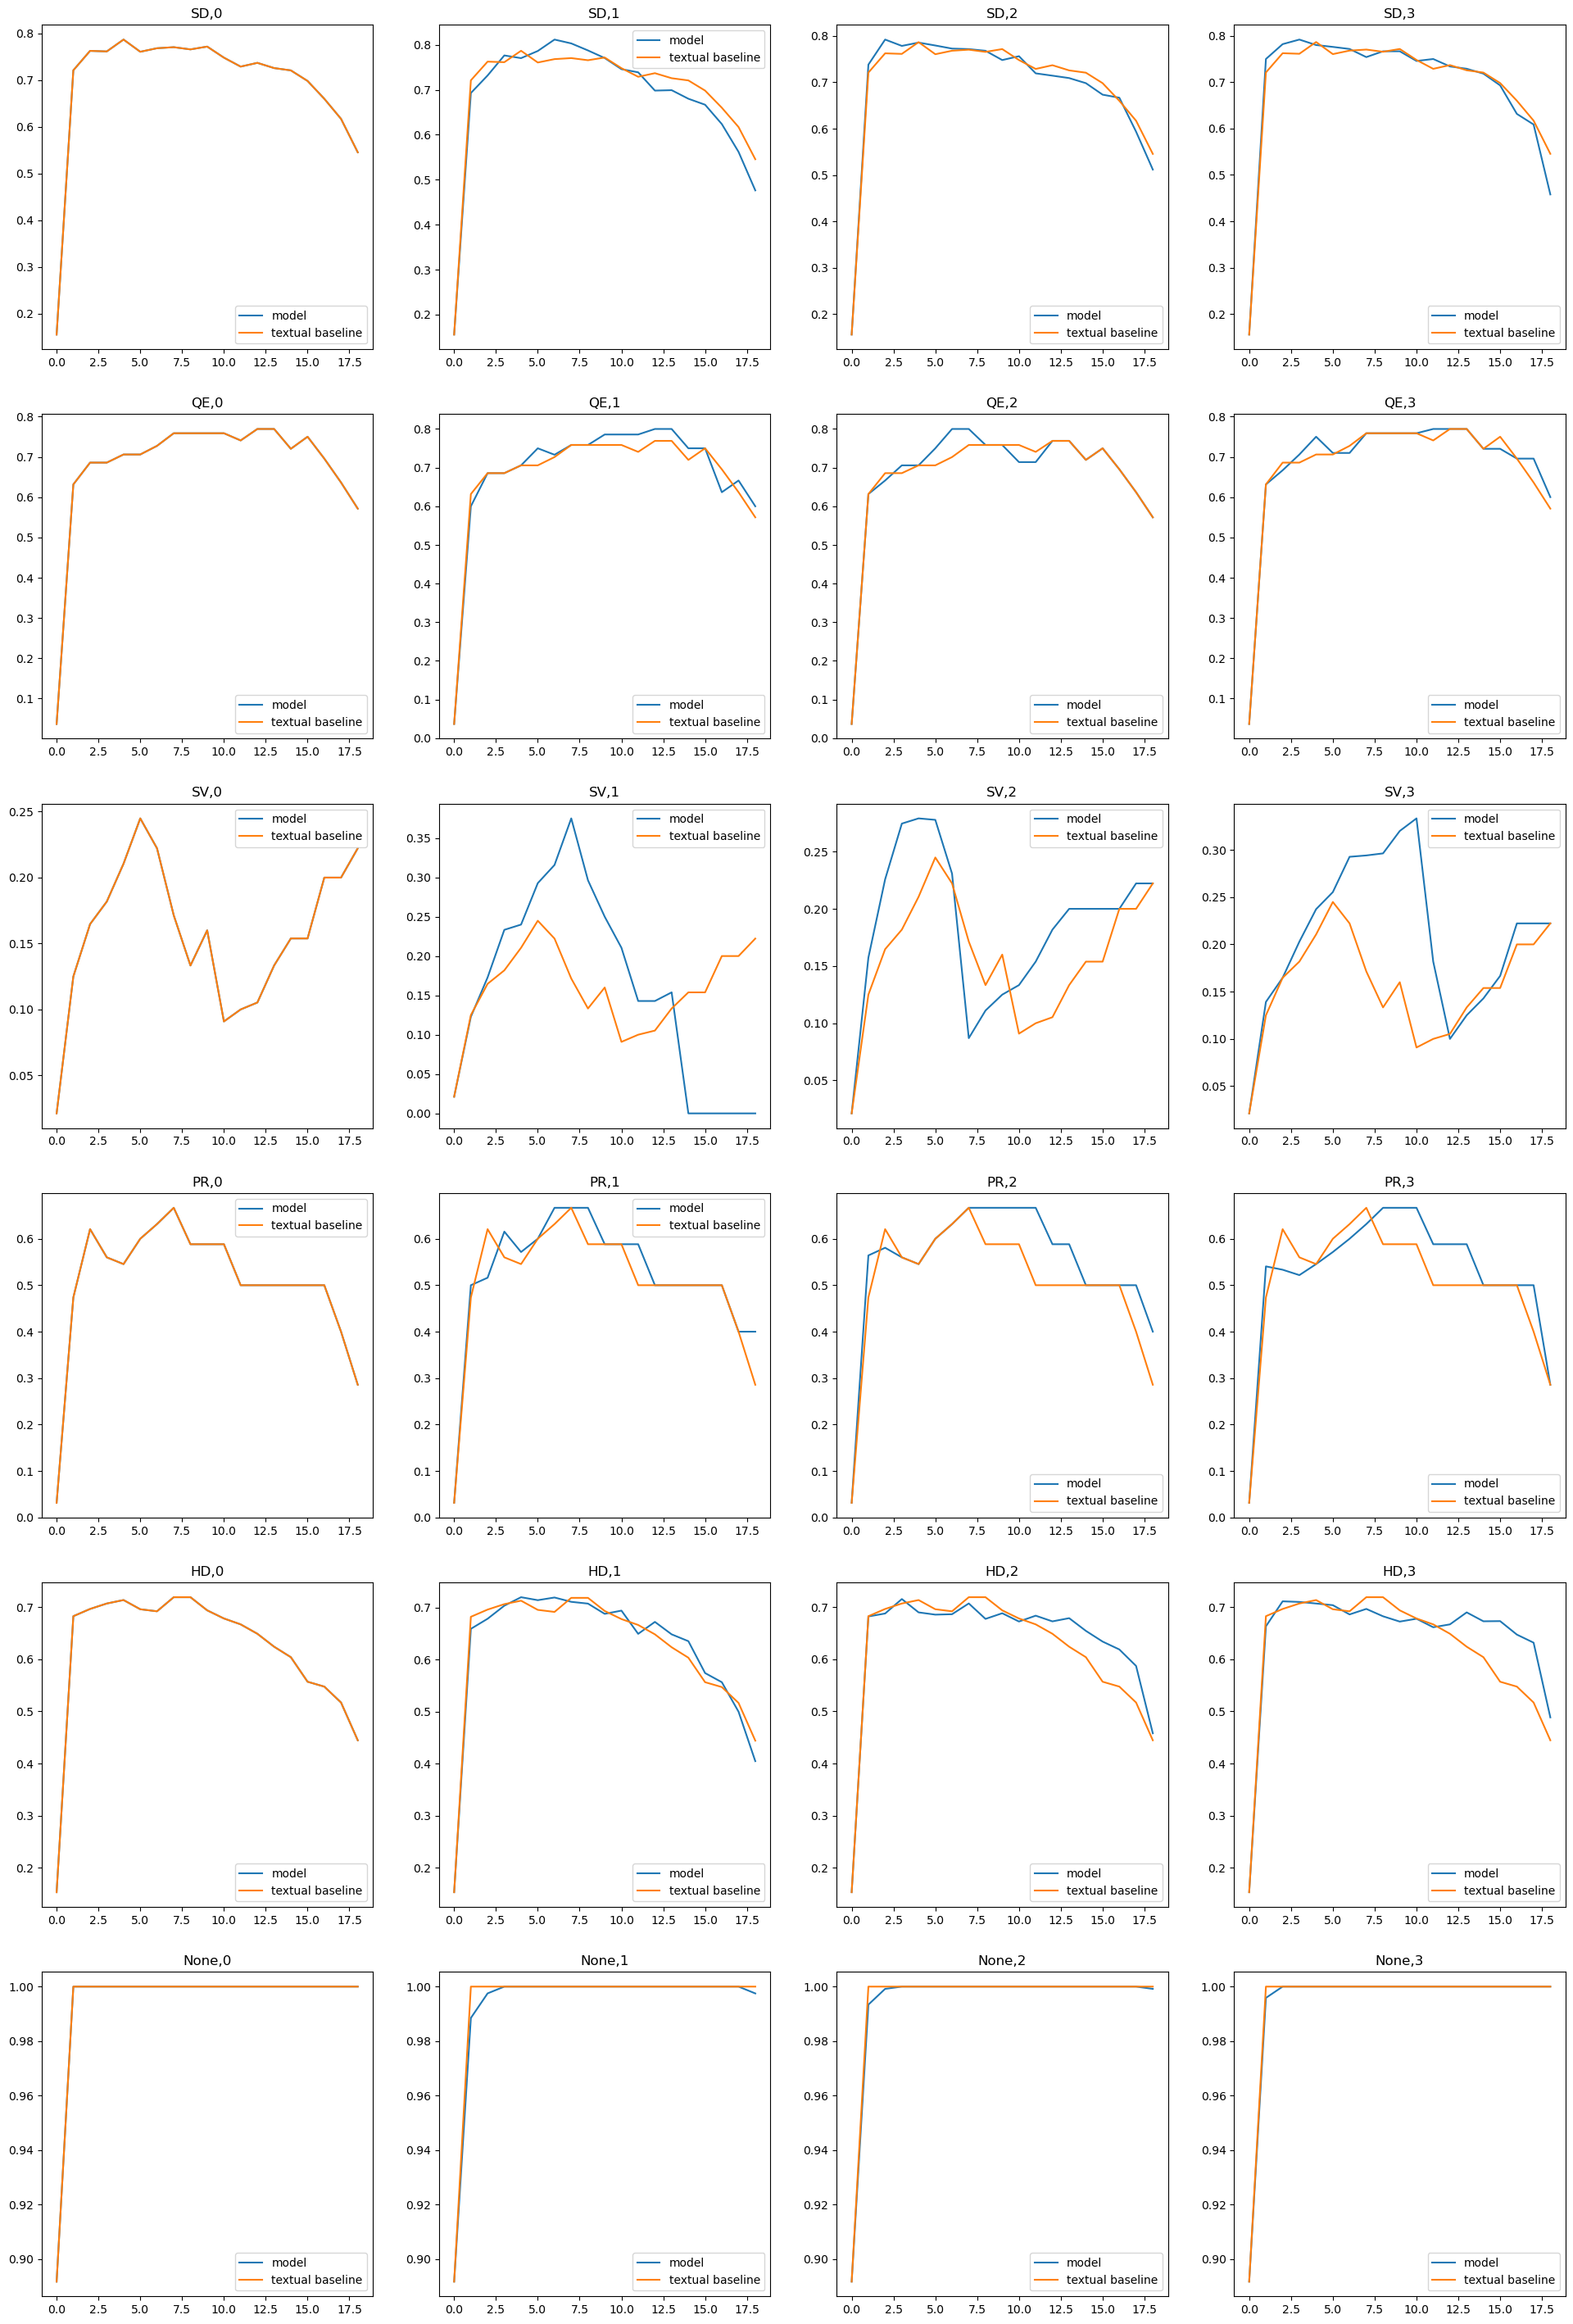

In [110]:
fig, axes = plt.subplots(6,4, figsize=(24,36))
for i, cat in enumerate(cats):
    for j, mod in enumerate(models):
        axes[i,j].plot(explore_tresh(true[cat],mod[cat])['F1 score'].values, label='model')
        axes[i,j].plot(explore_tresh(true[cat],text[cat])['F1 score'].values, label='textual baseline')
        #axes[i,j].set_title(f"{chi2(true[cat],mod[cat]):.4f}")
        axes[i,j].legend()
        
        # .plot(ax = axes[i,j], color =list(mcolors.TABLEAU_COLORS.values()) )
        # simulate_randomness(true[cat], mod[cat]).plot( ax=axes[i,j], linestyle='dashed',color =list(mcolors.TABLEAU_COLORS.values()))
        # axes[i,j].set_ylim(0,1)
        axes[i,j].set_title(f"{cat},{j}")

In [113]:
from sklearn.metrics import precision_score, recall_score
def precision_interval(true, pred):
    tresh = np.linspace(pred.min(),pred.max(),20)
    precision = np.array([ precision_score(true, np.where(pred>t,1,0), zero_division=1) for t in tresh[:-1] ])
    precision_interval = 1.96 * np.sqrt( precision * (1 - precision) / true.shape )
    precision = pd.Series(precision, index=tresh[:-1])
    return precision, precision + precision_interval, precision - precision_interval
def recall_interval(true, pred):
    tresh = np.linspace(pred.min(),pred.max(),20)
    recall = np.array([ recall_score(true, np.where(pred>t,1,0), zero_division=1) for t in tresh[:-1] ])
    recall_interval = 1.96 * np.sqrt( recall * (1 - recall) / true.shape )
    recall = pd.Series(recall, index=tresh[:-1])
    return recall, recall + recall_interval, recall - recall_interval
def f1_score_interval(true, pred):
    df_p = pd.concat(precision_interval(true,pred),axis=1)
    df_r = pd.concat(recall_interval(true,pred),axis=1)
    df_out = (2*df_p.multiply(df_r)).divide(df_p+df_r)
    df_out.columns = ['f1', 'top', 'bot']
    return df_out
    

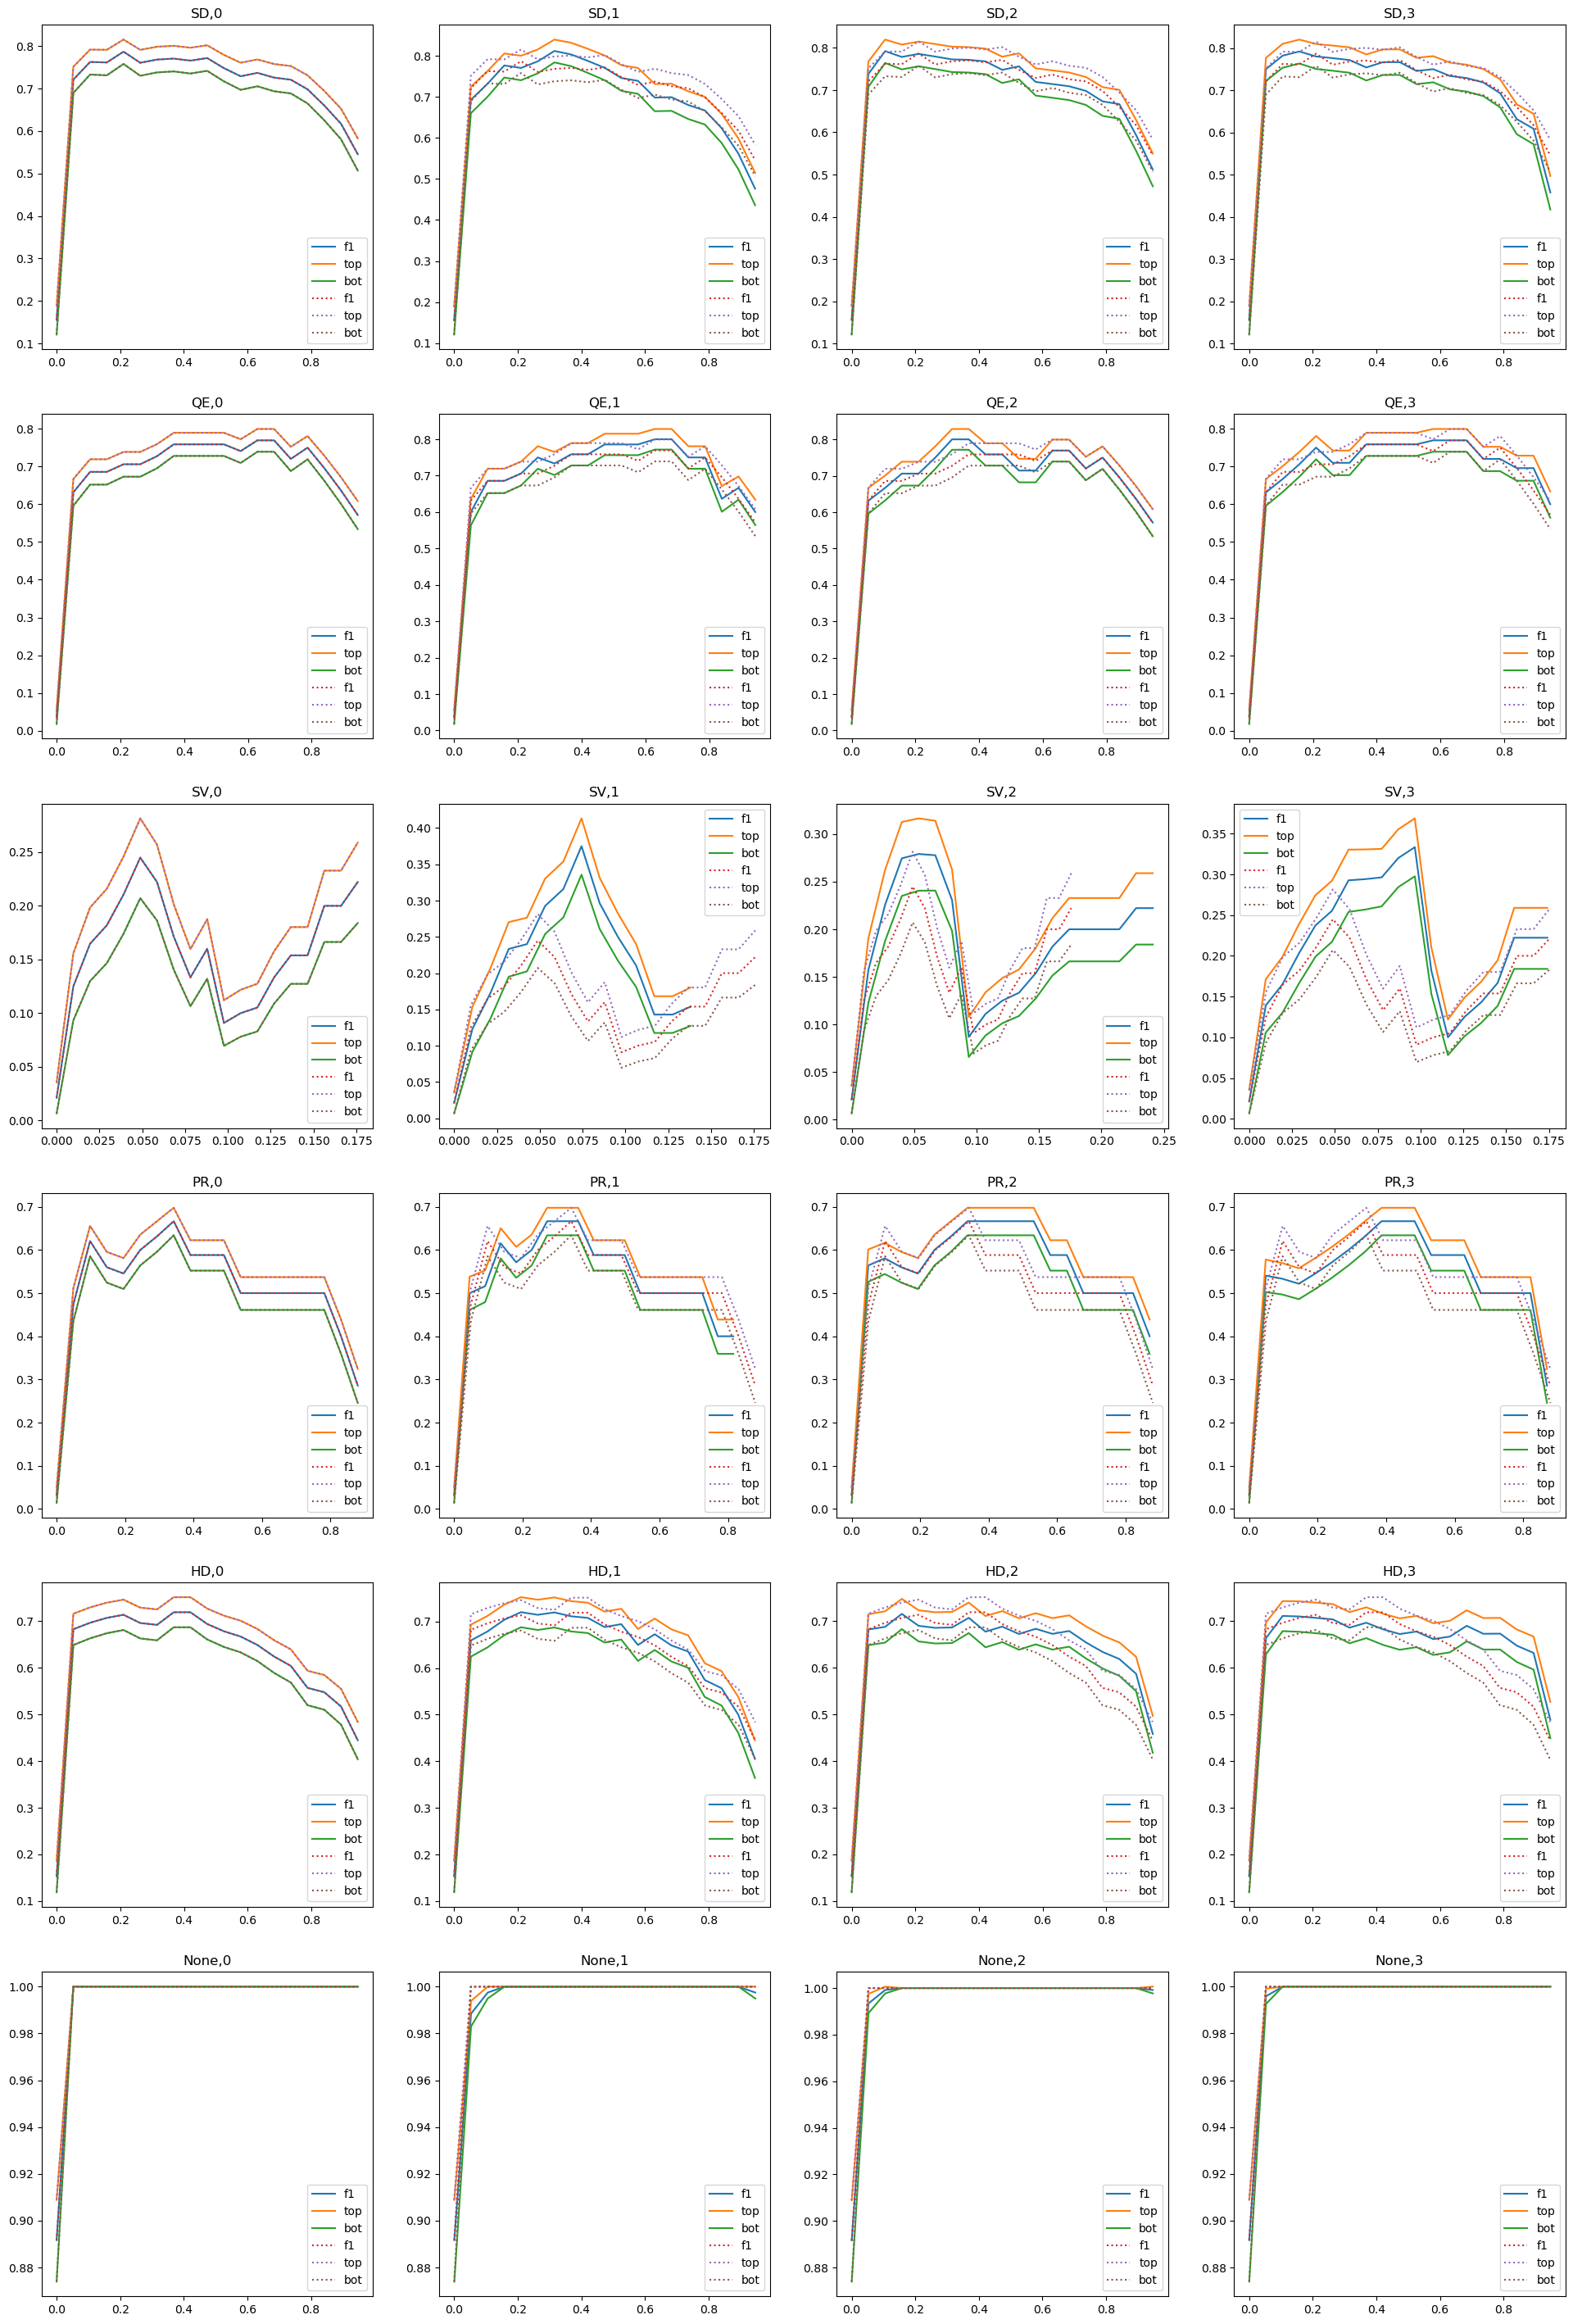

In [114]:
fig, axes = plt.subplots(6,4, figsize=(24,36))
for i, cat in enumerate(cats):
    for j, mod in enumerate(models):
        f1_score_interval(true[cat],mod[cat]).plot(ax=axes[i,j])
        f1_score_interval(true[cat],text[cat]).plot(ax=axes[i,j],linestyle='dotted')
        axes[i,j].set_title(f"{cat},{j}")